In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.datasets.samples_generator import make_blobs, make_circles
from sklearn.datasets import make_blobs, make_circles
from matplotlib import lines
from mpl_toolkits.mplot3d import Axes3D
import json
import math

In [3]:
def loadPrices(pricePath):
    with open(pricePath, "r") as priceFile:
        uuidToPrice = {}
        prices = json.load(priceFile)
        prices = prices['data']
        nonfoils = set() #Debug Sets
        foils = set()
        nones = set()
        for i in prices:
            if 'paper' in prices[i]:
                for vendor in prices[i]['paper']:
                    priced = False
                    for sellType in ['retail', 'buylist']:
                        if sellType in prices[i]['paper'][vendor]:
                            if 'normal' in prices[i]['paper'][vendor][sellType]:
                                uuidToPrice[i] = list(prices[i]['paper'][vendor][sellType]['normal'].values())[-1]
                                nonfoils.add(i)
                                priced = True
                                break
                            elif 'foil' in prices[i]['paper'][vendor][sellType]:
                                uuidToPrice[i] = list(prices[i]['paper'][vendor][sellType]['foil'].values())[-1]
                                foils.add(i)
                                priced = True
                                break
                            else:
                                print(f"No foil or nonfoil {i}")
                    if not priced:
                        nones.add(i)
        print(f"Loaded the Price of {len(uuidToPrice)}/{len(prices)} cards")
        return uuidToPrice

def loadCards(priceDict, cardPath):
    with open(cardPath, mode="r", encoding='utf-8') as cardFile:
        uuidToCardData = {}
        data = json.load(cardFile)
        data = data['data']
        priceMisses = set()
        for i in data:
            if data[i]['language'] == 'English' and 'legalities' in data[i] and 'MOM' not in data[i]['printings'] and i in priceDict and len(data[i]['legalities']) != 0:
                uuidToCardData[i] = data[i]
            if i not in priceDict:
                priceMisses.add(i)
        print(f"Loaded data of {len(uuidToCardData)}/{len(data)} cards")
        return uuidToCardData

mtgCardsPath = "../AllIdentifiers.json"
mtgPricesPath = "../AllPrices.json"
uuidToPrice = loadPrices(mtgPricesPath)
uuidToCard = loadCards(uuidToPrice,mtgCardsPath)

Loaded the Price of 71598/79853 cards
Loaded data of 61572/85169 cards


In [5]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [6]:
card_df = pd.DataFrame(uuidToCard.items())
price_df = pd.DataFrame(uuidToPrice.items())

In [7]:
card_df = card_df.rename(columns={0:"uuid", 1:"data"})
price_df = price_df.rename(columns={0:"uuid", 1:"price"})

In [8]:
card_price_df = card_df.merge(price_df, on=["uuid", "uuid"])
card_price_df = card_price_df.dropna(how='any',axis=0)

In [7]:
card_price_df

,uuid,data,price
0,00010d56-fe38-5e35-8aed-518019aa36a5,"{'artist': 'Lius Lasahido', 'availability': ['...",10.22
1,0001e0d0-2dcd-5640-aadc-a84765cf5fc9,"{'artist': 'Jesper Myrfors', 'availability': [...",5.12
2,0003caab-9ff5-5d1a-bc06-976dd0457f19,"{'artist': 'Drew Baker', 'availability': ['mtg...",4.35
3,0003d249-25d9-5223-af1e-1130f09622a7,"{'artist': 'Jason Chan', 'availability': ['mtg...",0.24
4,0004a4fb-92c6-59b2-bdbe-ceb584a9e401,"{'artist': 'Scott M. Fischer', 'availability':...",3.08
...,...,...,...
61567,fffa4546-e7ac-5291-b878-2e66ea1b1dfa,"{'artist': 'Aaron Miller', 'availability': ['m...",0.22
61568,fffa4ccf-733e-513a-98f9-181b9549de62,"{'artist': 'Christine Choi', 'availability': [...",6.59
61569,fffa9242-6444-567c-a45b-da2b45249232,"{'artist': 'Bastien L. Deharme', 'availability...",0.67
61570,fffb659e-b3fa-5cd8-9423-fe5ac74248b5,"{'artist': 'Dan Scott', 'availability': ['pape...",0.26


In [9]:
import random
def card_to_feature_vector(card):
    rarities = {
        "common": 0,
        "uncommon": 1,
        "rare": 2,
        "mythic": 3,
        "special": 4
    }
    
    out = [0] * 7
    out[rarities[card["data"]["rarity"]]] = 1
    out[5] = card["data"].get("convertedManaCost", 0)
    out[6] = random.randint(0,1)
    return out

featurized_df = card_price_df[["uuid", "data"]].copy()
featurized_df = featurized_df.apply(card_to_feature_vector, axis=1, result_type='expand')
labels = card_price_df["price"].apply(lambda p: math.floor(p))
print(featurized_df)

         0    1    2    3    4    5    6
0      0.0  0.0  0.0  1.0  0.0  7.0  0.0
1      0.0  0.0  1.0  0.0  0.0  3.0  1.0
2      1.0  0.0  0.0  0.0  0.0  1.0  0.0
3      1.0  0.0  0.0  0.0  0.0  5.0  1.0
4      0.0  1.0  0.0  0.0  0.0  3.0  1.0
...    ...  ...  ...  ...  ...  ...  ...
61567  0.0  1.0  0.0  0.0  0.0  3.0  1.0
61568  0.0  1.0  0.0  0.0  0.0  0.0  0.0
61569  0.0  0.0  1.0  0.0  0.0  5.0  1.0
61570  0.0  0.0  1.0  0.0  0.0  3.0  0.0
61571  0.0  1.0  0.0  0.0  0.0  1.0  0.0

[61572 rows x 7 columns]


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


#n_components = 2
#tsne = TSNE(n_components)
#tsne_result = tsne.fit_transform(featurized_df)

train, test, train_labels, test_labels = train_test_split(featurized_df,
                                                          labels,
                                                          test_size=0.2,
                                                          random_state=42)

train = train.head(1000)
train_labels = train_labels.head(1000)

# Initialize our classifier
clf = SVC()

# Train our classifier
model = clf.fit(train, train_labels)

#Make predictions
pred_train = model.predict(train)
pred_test = model.predict(test)  

print('Train Accuracy = ',accuracy_score(train_labels,pred_train.round()))
print('Test Accuracy = ',accuracy_score(test_labels,pred_test.round()))

Train Accuracy =  0.595
Test Accuracy =  0.6016240357287861


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score


#n_components = 2
#tsne = TSNE(n_components)
#tsne_result = tsne.fit_transform(featurized_df)

train, test, train_labels, test_labels = train_test_split(featurized_df,
                                                          labels,
                                                          test_size=0.2,
                                                          random_state=42)


# Initialize our classifier
clf = RandomForestRegressor()

# Train our classifier
model = clf.fit(train.head(1000), train_labels.head(1000))

pred_train = clf.predict(test)

# Evaluate accuracy
print(accuracy_score(y, np.argmax(pred_train, axis=1)))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

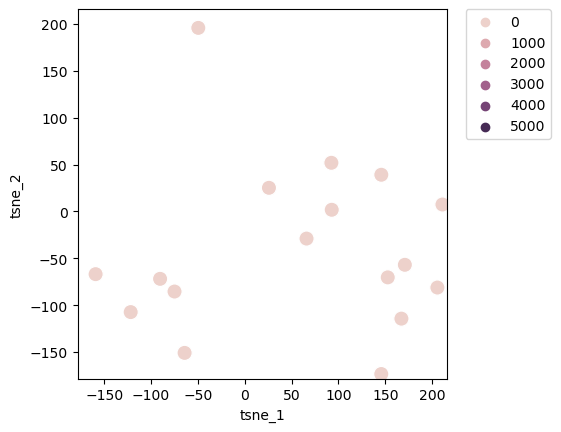